# Table of contents  <a name="toc"></a>
1. [Data](#data)
    1. [Loading data](#loadingdata)
2.[Utilities](#util)
3.[Helper Functions](#helper)
4.[FIGURE 2](#fig2)
5.[FIGURE 3](#fig3)
6.[FIGURE 4](#fig4)
7.[FIGURE 5](#fig5)
8.[FIGURE 6](#fig6)
9.[FIGURE 7](#fig7)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn
import scipy
from scipy.optimize import minimize,least_squares
import copy as copy
import time as tpy
import glob
import os
import pandas as pd
import pickle
from scipy.stats import wilcoxon as wilcoxon

# seaborn.set()

# DATA <a name="data"></a>

* refs: references
* poss: positions
* dec_vels: decoded velocities
* int_vels: intended velocities
* emgs: filtered EMGs
* Ws: weiner filter
* Hs: other filter
* alphas: learning rate
* pDs: penalty on decoder terms
* times: time
* conditions: which condition are we doing

UNPACKING: 

refs_block1, poss_block1, dec_vels_block1, int_vel_block1, emgs_block1, Ws_block1, Hs_block1, alphas_block1, pDs_block1, times_block1, conditions_block1

NOTE: 

* **CONDITIONS** = array(['D_1', 'D_2', 'D_5', 'D_6', 'D_3', 'D_4', 'D_7','D_8']
* **LEARNING RATES:** alpha = 0.25 and 0.75; alpha = 0.25 for D1, D2, D5, D6; alpha = 0.75 for D3, D4, D7, D8
* **SMOOTHBATCH:** W_next = alpha*W_old + ((1 - alpha) * W_calc)

* **DECODER INIT:** pos for D1 - D4, neg for D5 - D8

* **PENALTY TERM:** $\lambda_E$ = 1e-6 for all, $\lambda_F$ = 1e-7 for all, $\lambda_D$ = 1e-3 for 1, 3, 5, 7 and 1e-4 for 2, 4, 6, 8 


| DECODER | ALPHA | PENALTY | DEC INIT |
| --- | --- | --- | --- |
| 1 | 0.25 | 1e-3 | + |
| 2 | 0.25 | 1e-4 | + |
| 3 | 0.75 | 1e-3 | + |
| 4 | 0.75 | 1e-4 | + |
| 5 | 0.25 | 1e-3 | - |
| 6 | 0.25 | 1e-4 | - |
| 7 | 0.75 | 1e-3 | - |
| 8 | 0.75 | 1e-4 | - |


## Loading data <a name="loadingdata"></a>

back to top: [TOC](#toc)

In [2]:
#path = '/Users/mmadduri/OneDrive - UW/PhD_Research/Data/cphs-pilots'
#with open(path + '/cphs_data_block1.pickle', 'rb') as handle:
with open('cphs_data_block1.pickle', 'rb') as handle:
    refs_block1, poss_block1, dec_vels_block1, int_vel_block1, emgs_block1, Ws_block1, Hs_block1, alphas_block1, pDs_block1, times_block1, conditions_block1 = pickle.load(handle)
keys = ['METACPHS_S106', 'METACPHS_S107','METACPHS_S108', 'METACPHS_S109', 'METACPHS_S110', 'METACPHS_S111', 'METACPHS_S112']

#with open(path + '/cphs_data_block2.pickle', 'rb') as handle:
with open('cphs_data_block2.pickle', 'rb') as handle:
    refs_block2, poss_block2, dec_vels_block2, int_vel_block2, emgs_block2, Ws_block2, Hs_block2, alphas_block2, pDs_block2, times_block2, conditions_block2 = pickle.load(handle)
keys = ['METACPHS_S106', 'METACPHS_S107','METACPHS_S108', 'METACPHS_S109', 'METACPHS_S110', 'METACPHS_S111', 'METACPHS_S112']


In [3]:
key = keys[0]
alphas = alphas_block1[key]
alphas

array([0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75])

In [4]:
conds1 = conditions_block1[key]
print(conds1)

conds = conditions_block2[key]
print(conds)

['D_1' 'D_2' 'D_5' 'D_6' 'D_3' 'D_4' 'D_7' 'D_8']
['D_1' 'D_2' 'D_5' 'D_6' 'D_3' 'D_4' 'D_7' 'D_8']


In [5]:
pDs = pDs_block1[key]
pDs

array([0.001 , 0.0001, 0.001 , 0.0001, 0.001 , 0.0001, 0.001 , 0.0001])

# UTILITIES <a name="util"></a>

back to top: [TOC](#toc)

In [6]:
colors = dict()

colors['slow'] = '#9dc9ae'
colors['fast'] = '#38734e'

colors['first'] = np.array((239,237,245))/255
colors['last'] = np.array((117,107,177))/255

colors['first'] = 'whitesmoke'
colors['last'] = 'whitesmoke'

colors['pos_init'] = '#BDBDBD' #'paleturquoise'
colors['neg_init'] = '#676767' #'cadetblue'
colors['posneg'] = np.array((247,247,247))/255

colors['pD_3'] = '#1c364d' #'steelblue'
colors['pD_4'] = 'steelblue'#'lightsteelblue'

colors['ref'] = '#C55A11'
colors['curs'] = np.array((43, 140, 190))/255

# learning rate conditions
slow = [4, 5, 6, 7] # slow --> alpha = 0.75 bc 
fast = [0, 1, 2, 3]

# initialization conditions
pos_init = [0, 1, 4, 5]
neg_init = [2, 3, 6, 7]

# penalty parameter conditions
pD_3 = [0, 2, 4, 6] # pD = 1e-3
pD_4 = [1, 3, 5, 7] # pD = 1e-4

# set figure size
fw = 12
fh = 8
lbl_size = 27
tck_size = 24


Check that I did this separation correctly -- this will print an error if this is not correct

In [7]:
# will print error if this is not correct
assert((conds[pos_init] == ['D_1', 'D_2', 'D_3', 'D_4']).all())
assert((conds[neg_init] == ['D_5', 'D_6', 'D_7', 'D_8']).all())

assert((pDs[pD_3] == 1e-3).all())
assert((pDs[pD_4] == 1e-4).all())
assert((pDs[pD_3] != 1e-4).any())
assert((pDs[pD_4] != 1e34).any())

assert((alphas[slow] == 0.75).all())
assert((alphas[fast] == 0.25).all())
assert((alphas[slow] != 0.25).any())
assert((alphas[fast] != 0.75).any())

# HELPER FUNCTIONS  <a name="helper"></a>

back to top: [TOC](#toc)

### find trial length 
Trials might not all have the same time length, so this finds the minimum length and then sets all trials to that

In [8]:
min_time = 1e5
cond_num = 1
for key in keys:
    for cond in range(cond_num):
        if refs_block1[key][cond].shape[0] < min_time:
            min_time = refs_block1[key][cond].shape[0] 
min_time # 20770 for ~5 minutes

20770

### find decoder updates

Indexing the trials when the decoder actually updates

In [9]:
# trying to figure out how often decoder updates -- every 1202 samples

W = Ws_block1[keys[0]][0]
W[1:,:,:].shape # 7199 time points x (decoder dimensions is 2 x 6)
dold = W[0]
update_ix = []
for ix,d in enumerate(W[1:]):
  if (np.array_equal(dold,d)==False):
    update_ix.append(ix)
    dold = d

update_ix.append(len(W) - 1) 
update_ix = np.asarray(update_ix)
update_ix = np.hstack([[0],update_ix])
print("update index in time indices")
print(update_ix)

# only go up to 20432

update_times = times_block1[keys[0]][0][update_ix]
print("")
print("update times in seconds")
print(update_times)

update_mins = update_times/60
print("")
print("update times in minutes")
print(update_mins)

tscale = update_ix[-1]/update_times[-1]
print("")
print("time scale conversion (index --> seconds): ", tscale)

update index in time indices
[    0  1200  2402  3604  4806  6008  7210  8412  9614 10816 12018 13220
 14422 15624 16826 18028 19230 20432 20769]

update times in seconds
[  0.          16.81372571  33.70942521  50.44435     67.45188546
  84.74962473 101.82288647 118.90209508 136.32002926 153.7001555
 170.77472734 188.02292895 205.35715556 222.46085095 239.64881945
 256.75217056 274.14669037 291.41761136 296.34003878]

update times in minutes
[0.         0.28022876 0.56182375 0.84073917 1.12419809 1.41249375
 1.69704811 1.98170158 2.27200049 2.56166926 2.84624546 3.13371548
 3.42261926 3.70768085 3.99414699 4.27920284 4.56911151 4.85696019
 4.93900065]

time scale conversion (index --> seconds):  70.08502828627614


In [10]:
# set variable of ramp time
RAMP = int(tscale*5)
print(RAMP)

350


### time-domain error and function test

Plotting time-domain error across decoder updates

In [11]:
def calc_time_domain_error(X, Y):
    """calc_time_domain_error

    Args:
        X (n_time x n_dim): time-series data of position, e.g. reference position (time x dimensions)
        Y (n_time x n_dim): time-series data of another position, e.g. cursor position (time x dimensions)

    Returns:
        td_error (n_time x 1): time-series data of the Euclidean distance between X position and Y position
    """
    # make sure that the shapes are the same
    assert(X.shape == Y.shape)

    td_error = np.linalg.norm(X - Y, axis=1)

    return td_error

In [12]:
# test calc_time_domain_error to make sure the calculation makes sense

# Simple 1D Test: X = 0, Y = +/- 1
X = np.zeros((5, 1))
Y = np.asarray([[1], [-1], [1], [-1], [-1]])

# The distance between these coordinates should all be equal to 1
print(calc_time_domain_error(X, Y))
assert(np.allclose(calc_time_domain_error(X, Y), np.ones((5, 1))))
        
# try this in the 2D case: X = [0, 0]; Y = [+/- 1, +/- 1]
X = np.zeros((5, 2))
Y = np.asarray([[1, 1], [1, -1], [-1, 1], [-1, -1], [1, 1]])

# The distance between all these coordinates should be equal to the sqrt(2) -- sqrt(1^2 + 1^2) = sqrt(2)
print(calc_time_domain_error(X, Y))
assert(np.allclose(calc_time_domain_error(X, Y), np.ones((5))*np.sqrt(2)))

# Also confirm that this calculation = sqrt( (X[0]-Y[0]^2) + (X[1]-Y[1]^2) )
XY = np.sqrt((X[:, 0] - Y[:, 0])**2 + (X[:, 1] - Y[:, 1])**2) 

# confirms that this scales with Y = [+/- 2, +/- 2]
Y = Y*2
print(calc_time_domain_error(X, Y))
assert(np.allclose(calc_time_domain_error(X, Y), np.ones((5))*np.sqrt(8)))

[1. 1. 1. 1. 1.]
[1.41421356 1.41421356 1.41421356 1.41421356 1.41421356]
[2.82842712 2.82842712 2.82842712 2.82842712 2.82842712]


### plotting Wilcoxon boxplots

In [13]:
def calcAndPlotWilcoxonBoxplot(data1, data2, data_size, xlabel1, xlabel2, color1='slow', color2='fast', fig=plt, ax=plt):
    bplot = ax.boxplot([np.ndarray.flatten(data1), np.ndarray.flatten(data2)], 
                    showfliers=False,patch_artist=True,medianprops=dict(color='k'))

    if colors is not None:
       for patch, color in zip(bplot['boxes'], [colors[color1],colors[color2]]):
           patch.set_facecolor(color)
        
    assert(len(data1) == data_size)
    assert(len(data2) == data_size)
    assert(np.ndarray.flatten(data1) == np.ndarray.flatten(data2))
    
    ax.set_xticks([1, 2],[xlabel1, xlabel2])

    w = wilcoxon(np.ndarray.flatten(data1), np.ndarray.flatten(data2))
    
    return w

### plotting helper functions

(1) make font look like LaTex

(2) remove axes on frames

In [14]:
import matplotlib 

font = {#'family' : 'normal',
        'weight' : 'ultralight',
        'size'   : 14}
matplotlib.rc('font', **font)
from matplotlib import rcParams
rcParams['axes.titlesize'] = 16
rcParams['font.weight'] = 'ultralight'
rcParams['font.family'] = 'sans-serif'
rcParams['mathtext.fontset'] = 'cm'

In [15]:
def remove_and_set_axes(axs):
    
    '''
    desc: removes the box around the axs and the ticks 
    
    inputs:
    axs = the axs of the figure
    '''

    axs.spines["top"].set_visible(False)
    axs.spines["right"].set_visible(False)
    axs.spines["bottom"].set_visible(False)
    axs.spines["left"].set_visible(False)

    axs.tick_params(axis='x', labelsize=tck_size)
    axs.tick_params(axis='y', labelsize=tck_size)

In [16]:
# convolving by a bunch of 1's -- a moving average box or low-pass filter
# see: https://danielmuellerkomorowska.com/2020/06/02/smoothing-data-by-rolling-average-with-numpy/
def smooth(data, kernal_size = 10, mode='valid'):
    '''
    desc: smooths out a function by convolving the function with ones (a moving average)
    
    inputs:
    data = samples (Y,)
    kernal_size = number of points to convolve over (M, )
    mode = 'valid', 'full', 'same' 
    
    see: https://numpy.org/doc/stable/reference/generated/numpy.convolve.html for modes and sizes
    '''
    kernal = np.ones(kernal_size)/kernal_size
    data_smooth = np.convolve(data, kernal, mode=mode)
    return data_smooth

In [17]:
def plot_smooth_time_domain(t, data, axis = (0, 1, 2), kernal_size = 10,
                     color = 'k', lw = 3, alpha = 0.2, ax = None, ls='-', label=''):
    
    '''
    create time series plot showing median and interquartile 
    smooth time-domain data if chosen
    
    data -- (N, M....) x s -- N trials with s samples
    '''
    
    if ax is None:
        fig,ax = plt.subplots(1,1,sharex=True, figsize=(fw, fh))
    
    remove_and_set_axes(ax)
    
    d25, d50, d75 = np.percentile(data, [25, 50, 75], axis = axis)
    assert(data.shape[axis] == len(keys))
    
    # smooth time-series data    
    d25 = smooth(d25, kernal_size, mode='valid')
    d50 = smooth(d50, kernal_size, mode='valid')
    d75 = smooth(d75, kernal_size, mode='valid') # shape = data.shape[-1] - ks + 1

    ax.fill_between(time_x[kernal_size-1:], d25, d75, alpha=alpha, color=color)
    ax.plot(time_x[kernal_size-1:], d50, ls, color=color, linewidth=lw, label=label)
    ax.plot(time_x[kernal_size-1:], d25, ls, alpha=0.5, color=color, linewidth=1)
    ax.plot(time_x[kernal_size-1:], d75, ls, alpha=0.5, color=color, linewidth=1)

## FIGURE 2 - time-domain ref vs cursor plot of representative subject  <a name="fig2"></a>

Aim of this plot is to show the improvement of the user

back to top: [TOC](#toc)

In [18]:
xmax = max(refs_block1['METACPHS_S106'][0][:, 0])
ymax = max(refs_block1['METACPHS_S106'][0][:, 1])
xscale = 50/xmax
yscale = 50/ymax

assert(xmax*xscale == 50)

In [19]:
def plot_time_domain_ref_curs(time, r, p, 
                              cr = colors['ref'], cp = colors['curs'], 
                              r_mkr = '--', r_lw = 3, rlabel = r'$\tau$', 
                              c_mkr = '-', c_lw = 3, clabel = '$y$', FrameBool = False, fig = None, ax = None):
    if ax is None:
        fig,ax = plt.subplots(1,1,sharex=True, figsize=(7,3))
    
    ax.plot(time, r, r_mkr, color = cr, linewidth = r_lw, label = rlabel);
    ax.plot(time, p, c_mkr, color = cp, linewidth = c_lw, label = clabel);
    
    ax.set_frame_on(FrameBool)
    ax.set_yticks([])

METACPHS_S106
D_7


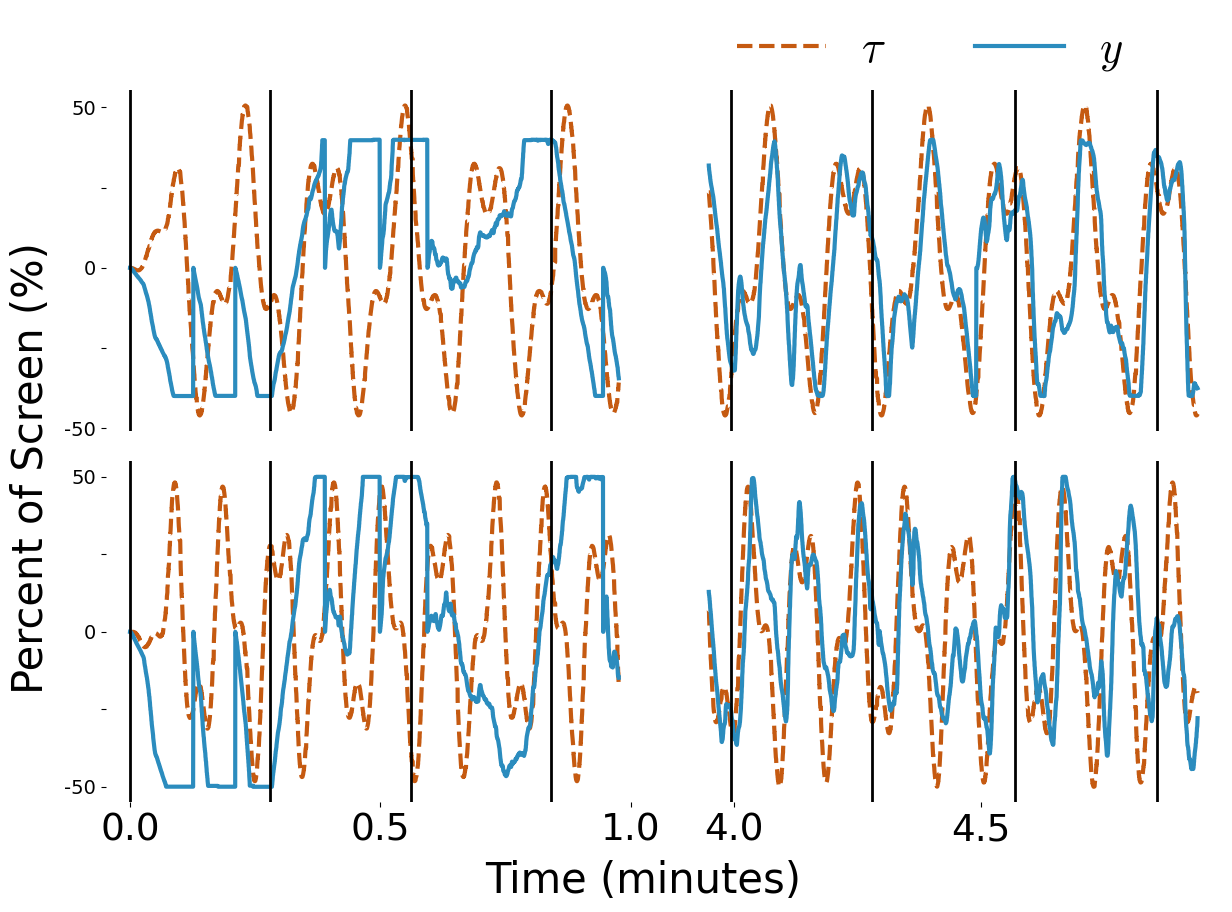

In [20]:
# choosing some random subject/condition that's done reasonably well (a.k.a. "representative subject")
k = keys[0]
c = 6

print(k)
print(conds[c])

# first minute
s0 = 0
s1 = int(min_time/5)

# last minute
s2 = int(4/5*min_time)
s3 = min_time

# set up figures
fig1, axs1 = plt.subplots(2, 2, figsize=(fw, fh))

# figure 1, axs1[0, 0] - x, first minute
ref_x = refs_block1[k][c][s0:s1, 0]
pos_x = poss_block1[k][c][s0:s1, 0]
time_x = times_block1[k][c][s0:s1]
plot_time_domain_ref_curs(time_x/60, ref_x*xscale, pos_x*xscale, fig = fig1, ax = axs1[0, 0])

# figure 1, axs1[0, 1] - x, last minute
ref_x = refs_block1[k][c][s2:s3, 0]
pos_x = poss_block1[k][c][s2:s3, 0]
time_x = times_block1[k][c][s2:s3]
plot_time_domain_ref_curs(time_x/60, ref_x*xscale, pos_x*xscale, fig = fig1, ax = axs1[0, 1])


# figure 1, axs1[1, 0] - y, first minute
ref_y = refs_block1[k][c][s0:s1, 1]
pos_y = poss_block1[k][c][s0:s1, 1]
time_y = times_block1[k][c][s0:s1]
plot_time_domain_ref_curs(time_y/60, ref_y*yscale, pos_y*yscale, fig = fig1, ax = axs1[1, 0])

# figure 1, axs1[1] - y, last minute
ref_y = refs_block1[k][c][s2:s3, 1]
pos_y = poss_block1[k][c][s2:s3, 1]
time_y = times_block1[k][c][s2:s3]
plot_time_domain_ref_curs(time_y/60, ref_y*yscale, pos_y*yscale, fig = fig1, ax = axs1[1, 1])


# frame, ticks
# x - first minute
axs1[0, 0].set_yticks([-50, -25, 0, 25, 50], ['-50', '','0', '', '50'])#, fontsize=24)
axs1[0, 0].set_xticks([])

# x - last minute
axs1[0, 1].set_xticks([])

# y - first minute
axs1[1, 0].set_yticks([-50, -25, 0, 25, 50], ['-50', '','0', '', '50'])#, fontsize=24)
axs1[1, 0].tick_params(axis='x', labelsize=lbl_size)

# y - last minute
axs1[1, 1].tick_params(axis='x', labelsize=lbl_size)

# set layout
fig1.tight_layout()

# # titles and labels
axs1[0, 1].xaxis.label.set_size(lbl_size)

# set vlines for decoder adaptations
for upd in update_mins[0:4]:
    axs1[0, 0].axvline(x=upd, color='black', linewidth=2)
    axs1[1, 0].axvline(x=upd, color='black', linewidth=2)

for upd in update_mins[-5:-1]:
    axs1[0, 1].axvline(x=upd, color='black', linewidth=2)
    axs1[1, 1].axvline(x=upd, color='black', linewidth=2)

fig1.text(-0.01, 0.23, 'Percent of Screen (%)', ha='center', rotation='vertical', fontsize=30)
fig1.text(0.5, -0.03, 'Time (minutes)', ha='center', fontsize=30)

# legend 
leg = axs1[0, 0].legend(prop={"size":16*2},frameon=False, 
                        fancybox=False, framealpha=0, 
                        ncol=2, bbox_to_anchor=(1.1, 1.3))


**FIGURE 2.** Comparison of target (red dashed trace, τ ) and cursor (blue straight trace, y) positions over time for an example trial for a representative subject. The y-axis is the display extent (%) and the x-axis is the time in minutes within the trial. The black vertical lines represent decoder adaptations. Horizontal (x) and vertical (y) positions shown in the top and bottom plots, respectively.

## FIGURE 3 - Average Time-Domain Tracking Error <a name="fig3"></a>

Compare the time-domain tracking error -- specifically the first 20 seconds post ramp (ramp is first 5 seconds) and the last 20 seconds

back to top: [TOC](#toc)

first 20 seconds after ramp, starting at index:  350 ending at index:  1751
last 20 seconds, starting at index:  1401


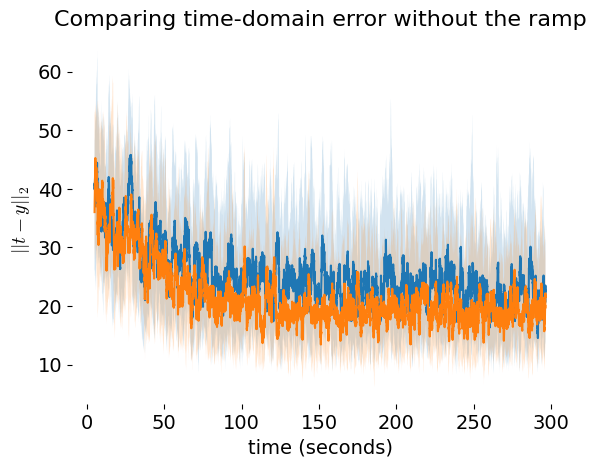

In [21]:
# Calculate the average time-domain error across all subjects

time_x = times_block1[k][c]
td_error = np.empty((2, len(keys), len(conds), min_time)) # len(update_ix)-2 so we can avoid the last interval

# get the time-domain error average across batches
for iK, key in enumerate(keys):
    for iC, cond in enumerate(conds):
        # BLOCK 1
        b = 0
        ref = refs_block1[key][iC] # ref = time x 2
        pos = poss_block1[key][iC] # pos = time x 2
        td_error[b, iK, iC, :] = calc_time_domain_error(ref, pos)
        
        # BLOCK 2
        b = 1
        ref = refs_block2[key][iC] # ref = time x 2
        pos = poss_block2[key][iC] # pos = time x 2
        td_error[b, iK, iC, :] = calc_time_domain_error(ref, pos)
        
# first 20 seconds after ramp 
t0_start = RAMP 
t0_end = int(tscale*25)-1 # so that both times are the same 
print("first 20 seconds after ramp, starting at index: ", t0_start, "ending at index: ", t0_end)

# take the average of the first 20 seconds across subjects, blocks and conditions
td_error_first = np.mean(td_error[:, :, :, t0_start:t0_end], axis = -1) # 2 x 7 x 8
assert(td_error_first.shape == (2, len(keys), len(conds)))

# last 20 seconds
t1_end = int(tscale*20)
print("last 20 seconds, starting at index: ", t1_end)

# make sure that the time lengths are the same
assert((t0_end - t0_start) == t1_end)

# take average of the last 20 seconds, across subjects blocks and conditions
td_error_last = np.mean(td_error[:, :, :, -t1_end:], axis=-1) # -t1_end takes the last 20 seconds index
assert(td_error_last.shape == (2, len(keys), len(conds)))

# BLOCK 1 - without the 5 seconds ramp
b = 0
td_b1_25, td_b1_50, td_bl_75 = np.percentile(td_error[b, :, :, t0_start:], [25, 50, 75], axis=(0, 1))
plt.plot(time_x[t0_start:], td_b1_50)
plt.fill_between(time_x[t0_start:], td_b1_25, td_bl_75, alpha=0.2)

# BLOCK 2 - without the 5 seconds ramp
b = 1
td_b2_25, td_b2_50, td_b2_75 = np.percentile(td_error[b, :, :, t0_start:], [25, 50, 75], axis=(0, 1))
plt.plot(time_x[t0_start:], td_b2_50)
plt.fill_between(time_x[t0_start:], td_b2_25, td_b2_75, alpha=0.2)

plt.title("Comparing time-domain error without the ramp")
plt.xlabel("time (seconds)")
plt.ylabel("$||t - y||_2$")
plt.box(False)

(7,)
WilcoxonResult(statistic=0.0, pvalue=0.015625)


Text(0.05, 0.08, 'better')

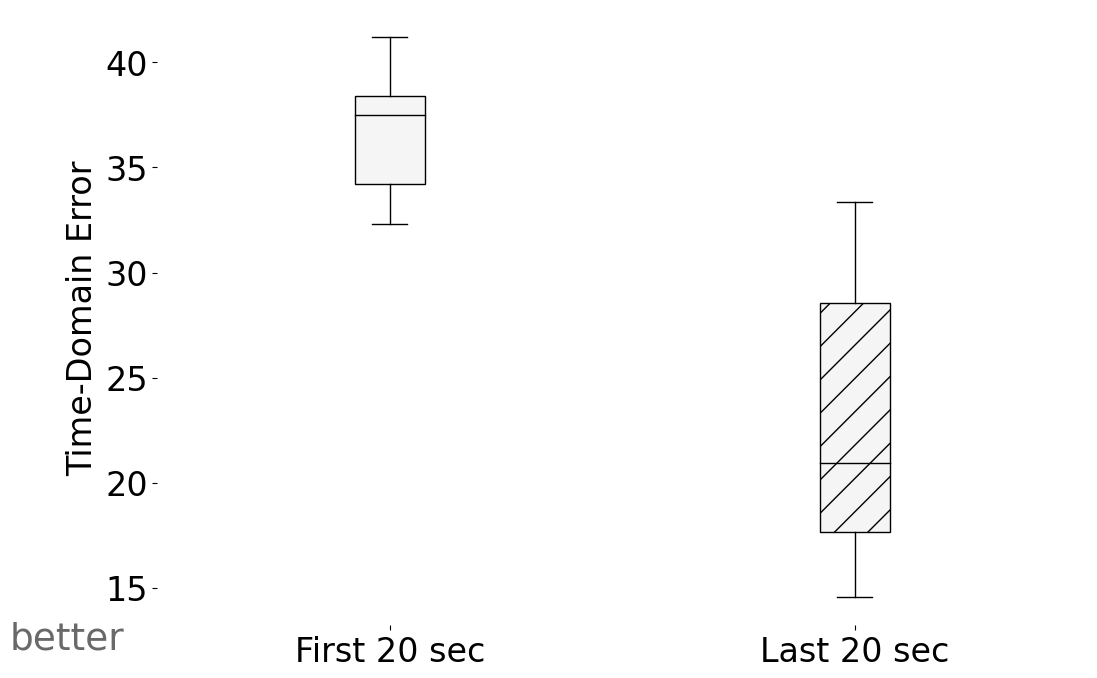

In [22]:
## WILCOXON

# first 20 seconds after ramp 
# take the average time across 20 seconds and then compare for the median per subject
td_error_first_med = np.median(td_error_first, axis = (0, 2))

# take the average time across 20 seconds and then compare for the median per subject
td_error_last_med = np.median(td_error_last, axis = (0, 2)) 

print(td_error_first_med.shape)

# make sure that the Wilcoxon comparisons here are N of 7
assert(td_error_first_med.size== len(keys)) # make sure the data is the number of subjects
assert(td_error_last_med.size == len(keys)) # make sure the data is the number of subjects

fig, axs = plt.subplots(1, 1, figsize=(fw, fh))
bplot = axs.boxplot([np.ndarray.flatten(td_error_first_med), np.ndarray.flatten(td_error_last_med)], 
                    showfliers=False,patch_artist=True,medianprops=dict(color='k'))
t = 0
if colors is not None:
    for patch, color in zip(bplot['boxes'], [colors['first'], colors['last']]):
        patch.set_facecolor(color)
        t = t + 1
        if t == 2:
            patch.set(hatch = '/')      
axs.set_xticks([1, 2],['First 20 sec', 'Last 20 sec'])
axs.xaxis.label.set_size(tck_size)
axs.yaxis.label.set_size(tck_size)

w = wilcoxon(np.ndarray.flatten(td_error_first_med), np.ndarray.flatten(td_error_last_med)) 
print(w)

# fig.tight_layout()

# set labels and axes
remove_and_set_axes(axs)
axs.set_ylabel('Time-Domain Error', fontsize=tck_size);
# fig.suptitle("Time-Domain, Wilcoxon (N = " + str(len(td_error_first_med)) + " , pval = " + str(w.pvalue) + ") ")
fig.text(0.05, 0.08, 'better', ha='center', fontsize=lbl_size, color='dimgray')

**FIGURE 3.** Average time domain tracking error ($||\tau - y||_2$) for the first 20 seconds and the last 20 seconds (each decoder batch time = 20 seconds). Median performance across all conditions (learning rates, decoder initializations, decoder cost weights, blocks) for each subject; statistical comparisons across subjects ($N=7$) with a paired Wilcoxon signed-rank test ($p = 0.016$).

## FIGURE 4 - Time-Domain Error vs Learning Rate <a name="fig4"></a>

* plot to show the significance of time-domain error of slow vs fast learning rate

back to top: [TOC](#toc)

**note: change to interquartile range for the 7**

N =  (7, 20420)


Text(0.05, 0.08, 'better')

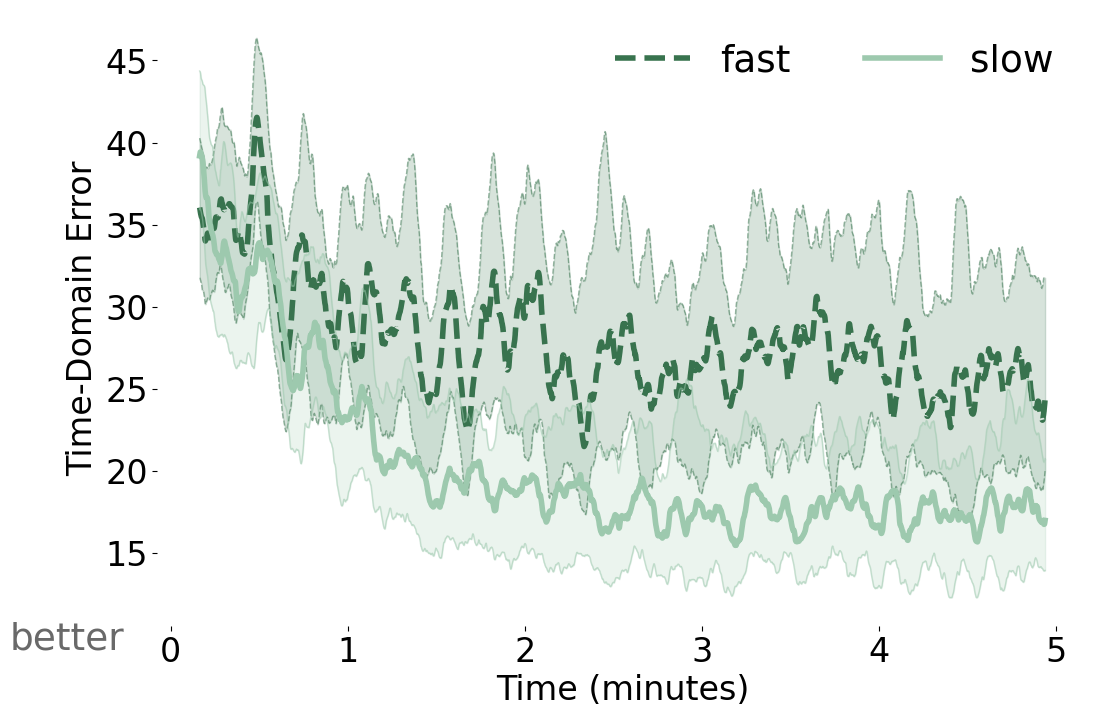

In [23]:
data_fast = np.median(td_error[:, :, fast, RAMP:], axis=(0, 2)) # (2, 7, 4, 20770)
data_slow = np.median(td_error[:, :, slow, RAMP:], axis=(0, 2)) # (2, 7, 4, 20770)

print("N = ", data_fast.shape)

axis = 0
ks = int(5*tscale) # time in seconds
time_x = times_block1[k][c][RAMP:]/60
fig,ax = plt.subplots(1,1,sharex=True, figsize=(fw,fh))

# # check to make sure that we're comparing N of keys across the 2 conditions
assert(data_fast.shape[axis] == len(keys))
assert(data_slow.shape[axis] == len(keys))

plot_smooth_time_domain(time_x, data_fast, ls='--', axis = axis, kernal_size = ks, ax=ax, color=colors['fast'], lw=4, label='fast')
plot_smooth_time_domain(time_x, data_slow,  axis = axis, kernal_size = ks, ax=ax, color=colors['slow'], lw=4, label='slow')

# set legend and labels
ax.legend(fontsize=lbl_size, frameon=False, fancybox=False, framealpha=0, ncol=2)
ax.set(xlabel = 'Time (minutes)', ylabel = 'Time-Domain Error')
ax.xaxis.label.set_size(tck_size)
ax.yaxis.label.set_size(tck_size)
# ax.set_yticks([])

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)


# add the better label to the left
fig.text(0.05, 0.08, 'better', ha='center', fontsize=lbl_size, color='dimgray')

Fig. 4. Average time-domain task error over the five-minute trial, separated by decoder learning rate (slow
vs fast, N = 7). Error was at each time and smoothed with a low-pass filter over 5 seconds to make the plot more interpretable, but the trend of the data remains. Solid lines show the median, shading shows 25% interquartiles.

## FIGURE 5 - Relative Error <a name="fig5"></a>

* This takes the average error for the first 20 seconds (without ramp) and the last 20 seconds and computes the relative difference ( (final - init)/init x 100%)
* The median value for each subject across conditions and blocks is compared (using mean does not change significance)
* Significance does not change if only BLOCK 2 data is included, showing that learning effects do not interfere with the decoder adaptation
* The first plot is a helper plot to match the p-values to the conditions


back to top: [TOC](#toc)

In [24]:
# calculating relative errors
td_diff = (td_error_last - td_error_first)/td_error_first * 100
assert(td_diff.shape == (2, len(keys), len(conds)))

# SLOW, FAST
td_diff_slow = np.median(td_diff[:, :, slow], axis = (0, 2))
td_diff_fast = np.median(td_diff[:, :, fast], axis = (0, 2))

# POS V NEG DEC INIT
td_diff_pos = np.median(td_diff[:, :, pos_init], axis = (0, 2))
td_diff_neg = np.median(td_diff[:, :, neg_init], axis = (0, 2))


# LAMBDA HIGH VS LAMBDA LOW
td_diff_pD3 = np.median(td_diff[:, :, pD_3], axis = (0, 2))
td_diff_pD4 = np.median(td_diff[:, :, pD_4], axis = (0, 2))


learning rate, N =  (7,)
WilcoxonResult(statistic=0.0, pvalue=0.015625)
decoder init, N =  (7,)
WilcoxonResult(statistic=13.0, pvalue=0.9375)
penalty param, N =  (7,)
WilcoxonResult(statistic=10.0, pvalue=0.578125)


Text(0.75, 0, '(c)')

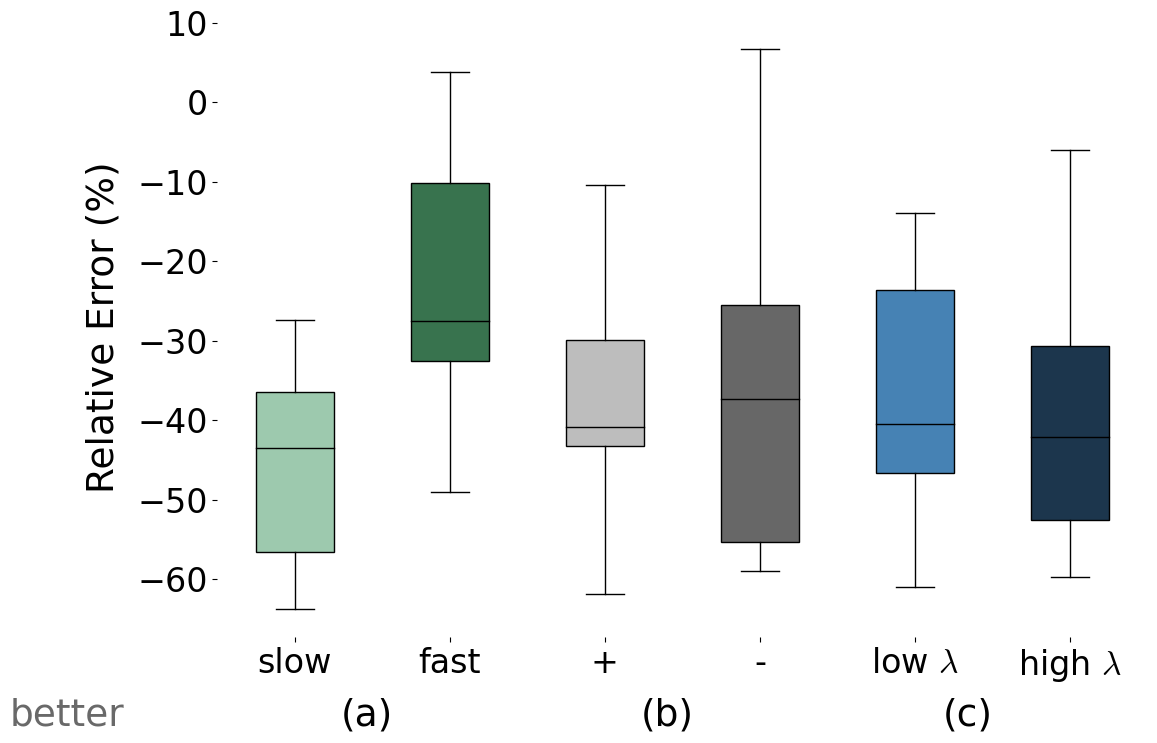

In [25]:
d1 = td_diff_slow
d2 = td_diff_fast
d3 = td_diff_pos
d4 = td_diff_neg
d5 = td_diff_pD4
d6 = td_diff_pD3


# check for shapes across comparison
assert(len(td_diff_slow) == len(keys))
assert(len(td_diff_fast) == len(keys))
assert(len(td_diff_pos) == len(keys))
assert(len(td_diff_fast) == len(keys))
assert(len(td_diff_pD3) == len(keys))
assert(len(td_diff_pD4) == len(keys))

fig,ax = plt.subplots(1,1,figsize=(fw, fh))
bplot = ax.boxplot([np.ndarray.flatten(d1), np.ndarray.flatten(d2), 
                    np.ndarray.flatten(d3), np.ndarray.flatten(d4),
                    np.ndarray.flatten(d5), np.ndarray.flatten(d6)], 
                    showfliers=False, patch_artist=True,medianprops=dict(color='k'));

if colors is not None:
       for patch, color in zip(bplot['boxes'], 
                               [colors['slow'], colors['fast'],
                                colors['pos_init'], colors['neg_init'],
                                 colors['pD_4'], colors['pD_3']]):
            patch.set_facecolor(color)
        
ax.set_xticks([1, 2, 3, 4, 5, 6],
              ['slow', 'fast', '+', '-', 'low $\lambda$', 'high $\lambda$']);


# learning rate
w = wilcoxon(np.ndarray.flatten(d1), np.ndarray.flatten(d2))
print("learning rate, N = ", d1.shape)
pv1 = w.pvalue
print(w)

# decoder init
w = wilcoxon(np.ndarray.flatten(d3), np.ndarray.flatten(d4))
print("decoder init, N = ", d1.shape)
pv2 = w.pvalue
print(w)

# penalty params
w = wilcoxon(np.ndarray.flatten(d5), np.ndarray.flatten(d6))
print("penalty param, N = ", d1.shape)
pv3 = w.pvalue
print(w)

# remove frames
remove_and_set_axes(ax)

# fig.suptitle("Relative Error, Wilcoxon | N = " + str(len(np.ndarray.flatten(d1))) 
#                                                     + ", p (learn) = " + str(pv1) + 
#                                                     ", p (init) = " + str(pv2) + 
#                                                     ", p (lambda) = " + str(pv3))
                                                    

# set texts and labels
fig.text(0.03, 0.3, 'Relative Error (%)', ha='center', rotation='vertical', fontsize=lbl_size)
fig.text(0, 0, 'better', ha='center', fontsize=lbl_size, color='dimgray')
fig.text(0.25, 0, '(a)', ha='center', fontsize=lbl_size, color='k')
fig.text(0.5, 0, '(b)', ha='center', fontsize=lbl_size, color='k')
fig.text(0.75, 0, '(c)', ha='center', fontsize=lbl_size, color='k')

FIGURE 5:

Relative Error is $\frac{error_{fi}}{error_{i}}\times 100\%$, where error$_{fi}$ = error$_{final}$ - error$_{initial}$ Median performance across all blocks and (a) for each learning rates for each subject, (b) for each decoder initialization for each subject, (c) for each decoder cost weight $\lambda$ for each subject; statistical comparisons across learning rates (N = 7) with a paired Wilcoxon signed-rank test ((a) $p = 0.016$, (b) $p = 0.938$, (c) $ p = 0.578$).}. Only (a) is statistically significant ($ p < 0.05$)

## FIGURE 6 - Decoder Distances <a name="fig6"></a>

What this does:

* take all the average last decoder: Dtrial
* Each subject has an average D+ and one average D- -- that's the last decoder for all positive init trials and negative init trials, respectively
* for each trial, we see how similar the Dtrial is to the D+ and Dtrial is the D-
* compare whether the Dtrials that are pos init are closer to D+ than Dtrials for neg init


back to top: [TOC](#toc)

++ to +-:  WilcoxonResult(statistic=0.0, pvalue=0.015625)
-- to -+:  WilcoxonResult(statistic=0.0, pvalue=0.015625)
+- to -+: WilcoxonResult(statistic=3.0, pvalue=0.078125)


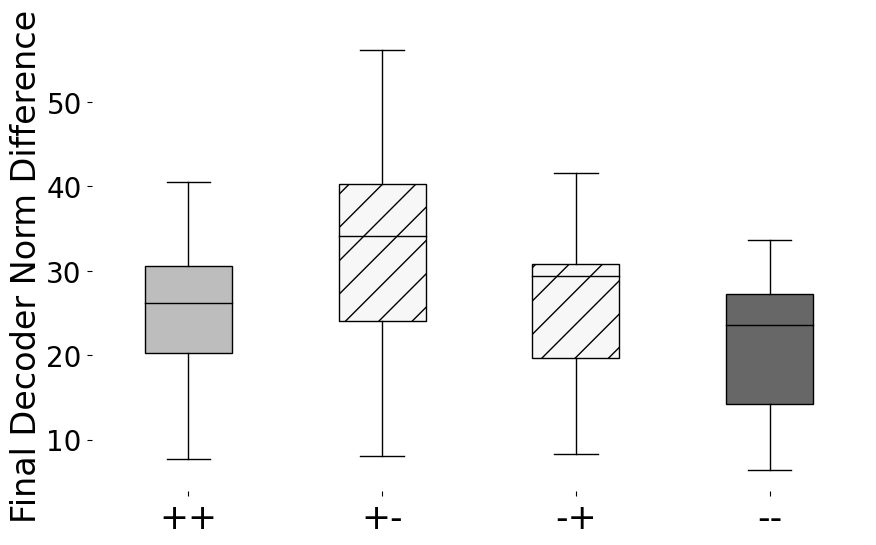

In [26]:
D_last = np.zeros((2, len(keys), len(conds), 2, 64)) # make an arry of the last decoders
for iK, key in enumerate(keys):
    # BLOCK 1
    b = 0
    D_last[b, iK] = np.mean(Ws_block1[key][:, update_ix, :, :][:, -3:], axis = 1) # average last 3 decoders
    
    # BLOCK 2
    b = 1
    D_last[b, iK] = np.mean(Ws_block2[key][:, update_ix, :, :][:, -3:], axis = 1)# average last 3 decoders

# get the last decoder for all pos init trials
Dp_all = D_last[:, :, pos_init] # 2 x 7 x 4 x 2 x 64
assert(Dp_all.shape == (2, len(keys), len(pos_init), 2, 64))

# get the last decoder for all neg init trials
Dn_all = D_last[:, :, neg_init]
assert(Dn_all.shape == (2, len(keys), len(pos_init), 2, 64))

# get last positive init decoder per person
Dp_subj = np.mean(D_last[:, :, pos_init], axis = (0, 2)) # 7 x 2 x 64
assert(Dp_subj.shape == (len(keys), 2, 64))

# get last negative init decoder per person
Dn_subj = np.mean(D_last[:, :, neg_init], axis = (0, 2))
assert(Dp_subj.shape == (len(keys), 2, 64))

# this takes the ||.||_F^2 of the difference between each decoder and the average of the final 
dpp = np.linalg.norm(Dp_all - Dp_subj[np.newaxis,:, np.newaxis], 'fro', axis=(-2, -1))**2 # (2, 7, 4)
dpn = np.linalg.norm(Dp_all - Dn_subj[np.newaxis,:, np.newaxis], 'fro', axis=(-2, -1))**2
dnn = np.linalg.norm(Dn_all - Dn_subj[np.newaxis,:, np.newaxis], 'fro', axis=(-2, -1))**2
dnp = np.linalg.norm(Dn_all - Dp_subj[np.newaxis,:, np.newaxis], 'fro', axis=(-2, -1))**2


# making sure that this is the squared euclidean distance
dpp1 = np.sum((Dp_all - Dp_subj[np.newaxis,:, np.newaxis])**2, axis = (-2, -1))
assert(np.allclose(dpp1, dpp))

# take average per subject --> Was changed to median
dpp = np.median(dpp,axis=(0, 2))
dpn = np.median(dpn,axis=(0, 2))
dnn = np.median(dnn,axis=(0, 2))
dnp = np.median(dnp,axis=(0, 2))

# make sure this is the len of subjects
assert(dpp.shape == (len(keys),))
assert(dpn.shape == (len(keys),))
assert(dnn.shape == (len(keys),))
assert(dnp.shape == (len(keys),))

# test significance between the decoder distance

# between D+_all and D+_subj and D+_all and D-_subj
# significance here means that initialization matters for +
wp = wilcoxon(dpp, dpn) 

# between D-_all and D-_subj and D-_all and D+_subj
# significance here means that intialization matters for -
wn = wilcoxon(dnn, dnp)

# between D+_all and D-_subj and D-_all and D+_subj
# no significance here means there's no difference in how much 
wpn = wilcoxon(dpn, dnp)

print("++ to +-: ", wp)
print("-- to -+: ", wn)
print("+- to -+:", wpn)


fig,ax = plt.subplots(1,1,figsize=(10,6))

bplot = ax.boxplot([dpp,dpn,dnp,dnn],showfliers=False,vert=True,patch_artist=True, medianprops=dict(color='k'))
idx = 0
if colors is not None:
    for patch, color in zip(bplot['boxes'], [colors['pos_init'],colors['posneg'],colors['posneg'],colors['neg_init']]):
        idx = idx + 1
        patch.set_facecolor(color)
        if idx == 2 or idx == 3:
            patch.set(hatch = '/')

plt.xticks([1,2,3,4],['++', '+-', '-+', '--'], fontsize=25)

# plt.title(r'Wilcoxon tests, Decoder Initializations' + "\n" + '($N=%d,\ p_{+-}=%0.3f,\ p_{-+}=%0.3f$)'%(dpp.size, wp.pvalue,wn.pvalue));
plt.yticks(fontsize=20)


# fig.text(0.06, 0.1, 'Final Decoder Norm Difference', ha='center', rotation='vertical', fontsize=tck_size)
fig.text(0.06, 0.07, 'Final Decoder Norm Difference', ha='center', rotation='vertical', fontsize=24)


# remove frame
for sp in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[sp].set_visible(False)

FIGURE 6. Average sum of squares difference (Euclidian distance) from the group mean for final decoders with both initializations ($||D_{final, avg} −D_{final,subj}||^2_F$). Statistical comparisons across subjects (N=7) with a
paired Wilcoxon signed-rank test (+−: p = 0.016,
−+: p = 0.016)

## FIGURE 7 - Decoder Cost <a name="fig7"></a>

FIGURE 7 in CPHS paper: Decoder norm ($||D||_F^2$) distributions (median, interquartile) for each decoder cost weight across blocks, subjects and other conditions (learning rate, decoder initialization). 

* the cost function is: $||error||_2^2 + ||D||_F^2 + ||F||_2^2$
* so $||D||_F^2$ = $ \sum{D_i^2} $ = $||vec(D)||_2^2$


back to top: [TOC](#toc)

In [27]:
def calc_matrix_norm(M):
    '''
    calculates the frobenius norm squared of a matrix M
    '''
    M_norm = np.linalg.norm(M,'fro')**2
    return M_norm

In [28]:
# test calc_matrix_norm

ii = 0
assert(Ws_block1[key][iC][update_ix].shape == (len(update_ix), 2, 64))
W_test = Ws_block1[key][iC][update_ix][ii] # get the ii-th W
assert(np.allclose(calc_matrix_norm(W_test), np.sum(W_test**2)))

N =  (7, 18)


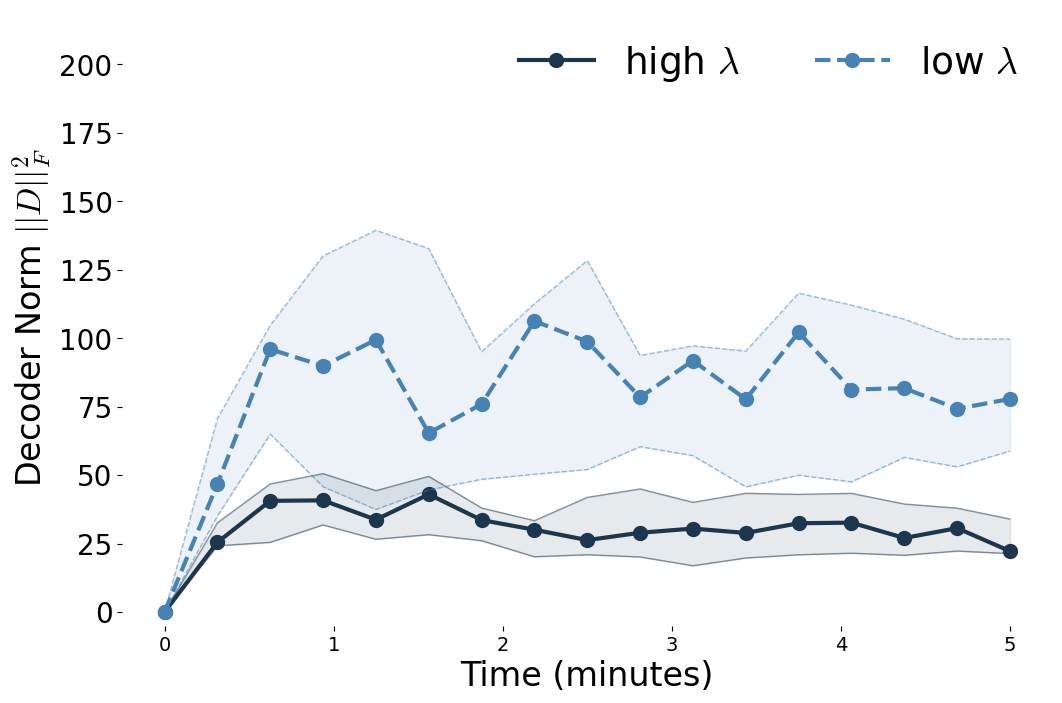

In [29]:
fig,ax = plt.subplots(1,1, figsize=(fw, fh))
D_norm = np.zeros((2, len(keys), len(conds), len(update_ix) - 1)) # 2 x 7 x 8 x 18
# update_ix - 1 because the last update is not evenly spaced

for iK, key in enumerate(keys):
    for iC, cond in enumerate(conds):
        # BLOCK 1
        b = 0
        W1 = Ws_block1[key][iC][update_ix] # so W1 = 19 x 2 x 64 
        D_norm[b, iK, iC, :] = np.asarray([calc_matrix_norm(W1[ii]) for ii in range(len(update_ix) - 1)])
        
        # BLOCK 2
        b = 1
        W2 = Ws_block2[key][iC][update_ix] # W2 = 19 x 2 x 64
        D_norm[b, iK, iC, :] = np.asarray([calc_matrix_norm(W2[ii]) for ii in range(len(update_ix) - 1)])    
            
# take the median per subject and then interquartile across subjects
D_norm_pd3 = np.median(D_norm[:, :, pD_3], axis = (0, 2)) # so each subject has a D_norm_pd3 plot
D_norm_pd4 = np.median(D_norm[:, :, pD_4], axis = (0, 2))
print("N = ", D_norm_pd3.shape)

axis = 0
# make sure the N's are correctly compared
assert(D_norm_pd3.shape[axis] == (len(keys,)))
assert(D_norm_pd4.shape[axis] == (len(keys,)))


# NOTE: taking the first time index (1:) off b/c it's the initial decoder and is very small in comparison -- looks weird on the graph
D_norm_pd3_25, D_norm_pd3_50, D_norm_pd3_75 = np.percentile(D_norm_pd3[:, 1:], 
                                                            [25, 50, 75] , axis=axis)
D_norm_pd4_25, D_norm_pd4_50, D_norm_pd4_75 = np.percentile(D_norm_pd4[:, 1:], 
                                                            [25, 50, 75] , axis=axis)


xn = np.linspace(0, 5, len(D_norm_pd3_50))
ax.fill_between(xn, D_norm_pd3_25, D_norm_pd3_75, 
                alpha=0.1, color = colors['pD_3'])
ax.fill_between(xn, D_norm_pd4_25, D_norm_pd4_75, 
                alpha=0.1, color = colors['pD_4'])

ax.plot(xn, D_norm_pd3_50, '-o', alpha=1, linewidth=3, markersize=10,
        color = colors['pD_3'], label = 'high $\lambda$')#, \lambda_D = 1e-3$')
ax.plot(xn, D_norm_pd3_75, '-', alpha=0.5, linewidth=1, color = colors['pD_3'])
ax.plot(xn, D_norm_pd3_25, '-', alpha=0.5, linewidth=1, color = colors['pD_3'])

ax.plot(xn, D_norm_pd4_50, '--o', alpha=1, linewidth=3, markersize=10, color = colors['pD_4'], label = 'low $\lambda$') #, \lambda_D = 1e-4$')
ax.plot(xn, D_norm_pd4_75, '--', alpha=0.5, linewidth=1, color = colors['pD_4'])
ax.plot(xn, D_norm_pd4_25, '--', alpha=0.5, linewidth=1, color = colors['pD_4'])


ax.legend(fontsize=lbl_size, frameon=False, fancybox=False, framealpha=0, ncol=2)

ax.set(xlabel = 'Time (minutes)', ylabel = 'Decoder Norm $||D||_F^2$')
ax.set_ylim([-5, 220])
ax.xaxis.label.set_size(tck_size)
ax.yaxis.label.set_size(tck_size)

ax.tick_params(axis='y', labelsize=20)


# remove frame
# ax.set_xticks()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)


In [30]:
len(D_norm_pd3_50)

17

## Kai's Edits

Fig 6

In [31]:
D_last = np.zeros((2, len(keys), len(conds), 2, 64)) # make an arry of the last decoders
for iK, key in enumerate(keys):
    # BLOCK 1
    b = 0
    D_last[b, iK] = np.mean(Ws_block1[key][:, update_ix, :, :][:, -3:], axis = 1) # average last 3 decoders
    
    # BLOCK 2
    b = 1
    D_last[b, iK] = np.mean(Ws_block2[key][:, update_ix, :, :][:, -3:], axis = 1)# average last 3 decoders

# get the last decoder for all pos init trials
Dp_all = D_last[:, :, pos_init] # 2 x 7 x 4 x 2 x 64
assert(Dp_all.shape == (2, len(keys), len(pos_init), 2, 64))

# get the last decoder for all neg init trials
Dn_all = D_last[:, :, neg_init]
assert(Dn_all.shape == (2, len(keys), len(pos_init), 2, 64))

# get last positive init decoder per person
Dp_subj = np.mean(D_last[:, :, pos_init], axis = (0, 2)) # 7 x 2 x 64
assert(Dp_subj.shape == (len(keys), 2, 64))

# get last negative init decoder per person
Dn_subj = np.mean(D_last[:, :, neg_init], axis = (0, 2))
assert(Dp_subj.shape == (len(keys), 2, 64))

In [32]:
D_last.shape

(2, 7, 8, 2, 64)

In [33]:
D_last[b, iK].shape

(8, 2, 64)

In [34]:
print(Dp_all.shape)
#(2, 7, 4, 2, 64) --> (blocks?, ?, half of the conditions, ?, channels)

(2, 7, 4, 2, 64)


In [35]:
# this takes the ||.||_F^2 of the difference between each decoder and the average of the final 
dpp = np.linalg.norm(Dp_all - Dp_subj[np.newaxis,:, np.newaxis], 'fro', axis=(-2, -1))**2 # (2, 7, 4)
dpn = np.linalg.norm(Dp_all - Dn_subj[np.newaxis,:, np.newaxis], 'fro', axis=(-2, -1))**2
dnn = np.linalg.norm(Dn_all - Dn_subj[np.newaxis,:, np.newaxis], 'fro', axis=(-2, -1))**2
dnp = np.linalg.norm(Dn_all - Dp_subj[np.newaxis,:, np.newaxis], 'fro', axis=(-2, -1))**2

In [36]:
print(dpp.shape)
print()
print(dpp)

(2, 7, 4)

[[[ 26.25673925  88.80632605  17.19598536  26.08003449]
  [ 22.30905898  60.57348493  14.27338289  59.87215914]
  [ 25.36247827 116.74228355  13.18322969  32.79854055]
  [ 18.80611902  19.63778153   5.70437887   5.09726703]
  [ 44.06304061  64.34118473  20.01456869  26.26736437]
  [ 22.21736103  55.98620822  18.44696533  29.60466334]
  [ 16.31794369  35.44454368   6.49117631   9.67672977]]

 [[ 17.97342449 228.34256245  10.76592876  27.66994298]
  [ 43.82170547  70.84169036  19.67544122  37.1896374 ]
  [ 63.38034495 140.32611821  15.38017786  27.69908807]
  [  4.55859877  17.33264576   4.50785745   9.69701016]
  [ 18.37585718  39.57654753   9.93644131  25.61584675]
  [ 46.44745775  94.28809742  15.1926257   32.07229784]
  [ 29.15272491  27.76343833  12.76617762   7.11429137]]]


In [37]:
# making sure that this is the squared euclidean distance
dpp1 = np.sum((Dp_all - Dp_subj[np.newaxis,:, np.newaxis])**2, axis = (-2, -1))
assert(np.allclose(dpp1, dpp))

# take average per subject --> Was changed to median
dpp = np.median(dpp,axis=(0, 2))
dpn = np.median(dpn,axis=(0, 2))
dnn = np.median(dnn,axis=(0, 2))
dnp = np.median(dnp,axis=(0, 2))

In [38]:
print(dpp.shape)
print()
print(dpp)

(7,)

[26.16838687 40.50567143 30.24881431  7.70069451 25.94160556 30.83848059
 14.54206066]


Fig 7

In [39]:
#D_norm = np.zeros((2, len(keys), len(conds), len(update_ix) - 1)) # 2 x 7 x 8 x 18
#(blocks?, subjects, trials, ?)
print(D_norm.shape)

(2, 7, 8, 18)
